- **Finetuning the convnet**: Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
- **ConveNet as fixed feature extractor**: Here, we will freeze weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


very small dataset

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.299, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/hymenoptera_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

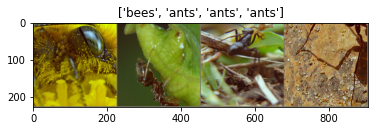

In [7]:
# visualize
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001) # pause a bit so that plots are updated

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

- Scheduling the learning rate
- Saving the best model

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-'*10)

    # training and validation phase for each epoch
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_correct = 0.0

      # Iteration
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # only in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_correct += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_correct.double() / dataset_sizes[phase]

      print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

      # deepcopy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  model.load_state_dict(best_model_wts)
  return model        

### Visualizint the model predictions

In [9]:
def visualize_model(model, num_images=6):
  was_training = model.training # default = True
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training) # def train(self: T, mode: bool = True) -> T:
          return                         # mode (bool): whether to set training mode ('True') or
    model.train(mode=was_training)       # evaluation mode ('False'). Default: 'True'

### Finetuning the convnet

In [10]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# the size of each output sample
# can be generalized to nn.Linear(num_ftrs, len(class_names))
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6585 Acc: 0.6434
val Loss: 0.2606 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.5603 Acc: 0.7541
val Loss: 0.8758 Acc: 0.7059

Epoch 2/24
----------
train Loss: 0.4898 Acc: 0.8115
val Loss: 0.2010 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.6188 Acc: 0.7582
val Loss: 0.3603 Acc: 0.8562

Epoch 4/24
----------
train Loss: 0.4760 Acc: 0.8033
val Loss: 0.3209 Acc: 0.8693

Epoch 5/24
----------
train Loss: 0.6586 Acc: 0.7787
val Loss: 0.4163 Acc: 0.8693

Epoch 6/24
----------
train Loss: 0.3409 Acc: 0.8525
val Loss: 0.7667 Acc: 0.8105

Epoch 7/24
----------
train Loss: 0.5419 Acc: 0.8115
val Loss: 0.2492 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3039 Acc: 0.8607
val Loss: 0.2137 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3699 Acc: 0.8730
val Loss: 0.1995 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3440 Acc: 0.8443
val Loss: 0.1888 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.2388 Acc: 0.8975
val Loss: 0.1648 Acc: 0.9412

Ep

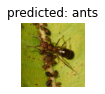

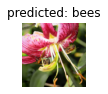

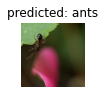

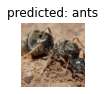

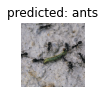

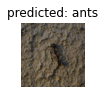

In [12]:
visualize_model(model_ft)

ConvNet as fixed feature extractor

In [15]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False

# parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Only parameters of final layer are being optimized as opposed to before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7864 Acc: 0.5902
val Loss: 1.2866 Acc: 0.5621

Epoch 1/24
----------
train Loss: 0.6300 Acc: 0.7500
val Loss: 0.1672 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.5089 Acc: 0.7787
val Loss: 0.1797 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.7574 Acc: 0.7131
val Loss: 0.2703 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.3811 Acc: 0.8566
val Loss: 0.5230 Acc: 0.7908

Epoch 5/24
----------
train Loss: 0.5026 Acc: 0.7951
val Loss: 0.1756 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.5851 Acc: 0.7623
val Loss: 0.1860 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3693 Acc: 0.8320
val Loss: 0.2082 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.2922 Acc: 0.8811
val Loss: 0.2101 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3065 Acc: 0.8566
val Loss: 0.2046 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3221 Acc: 0.8689
val Loss: 0.1932 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2907 Acc: 0.8689
val Loss: 0.2004 Acc: 0.9346

Ep

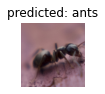

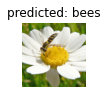

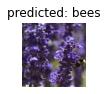

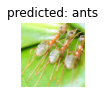

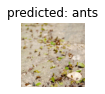

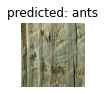

In [17]:
visualize_model(model_conv)